In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from rdkit import Chem
import plotly.graph_objs as go


In [3]:
results = pd.read_csv("data/cosine_hungarian_small_tolerances_results.tsv", sep='\t')

In [4]:
same_query_ref = results.loc[results['query'] == results['reference']]
same_query_ref.to_csv("data/same_query_ref.tsv", sep='\t', index=False)

In [5]:
#plt.hist(same_query_ref['CosineHungarian_score'], bins=10)

In [6]:
#plt.hist(same_query_ref['CosineHungarian_matches'], bins=10)

In [7]:
# Create a Histogram object
histogram = go.Histogram(x=same_query_ref['CosineHungarian_matches'], nbinsx=20)
layout = go.Layout(title='Histogram',
    xaxis_title='Number of peaks matched (Cosine Hungarian matches)',
    yaxis_title='Number of molecules',
    xaxis=dict(tickmode='linear',tick0=0,dtick=5),
    yaxis=dict(tickmode='linear',tick0=0,dtick=5))
figure = go.Figure(data=[histogram], layout=layout)
figure.show()

In [8]:
# Create a Histogram object
histogram = go.Histogram(x=same_query_ref['CosineHungarian_score'], nbinsx=40)
layout = go.Layout(title='Histogram',
    xaxis_title='Cosine Hungarian scores',
    yaxis_title='Number of molecules',
    xaxis=dict(tickmode='linear',tick0=0,dtick=0.05),
    yaxis=dict(tickmode='linear',tick0=0,dtick=5))
figure = go.Figure(data=[histogram], layout=layout)
figure.show()

In [9]:
molecules = Chem.SDMolSupplier("../data/RECETOX_GC-EI-MS_20201028.sdf")
class_names = pd.DataFrame({
    "class" : [m.GetProp("Class") for m in molecules],
    "name" : [m.GetProp("NAME") for m in molecules],
    "n_atoms" : [m.GetNumAtoms() for m in molecules]
})
merged_df = pd.merge(same_query_ref, class_names, left_on='query', right_on='name')

[11:31:27] Skipping unrecognized collection type at line 48576: MDLV30/STERAC1 BONDS=(1 7)
[11:31:27] Skipping unrecognized collection type at line 48576: MDLV30/STERAC1 BONDS=(1 7)
[11:31:27] Skipping unrecognized collection type at line 48576: MDLV30/STERAC1 BONDS=(1 7)


In [10]:
grouped_df = merged_df.groupby('class')['CosineHungarian_score'].agg(['count','min', 'max'])
grouped_df.to_csv("data/same_query_max_min_grouped.tsv", sep='\t', index=True)

In [11]:
def make_boxplot(grouped_df: pd.DataFrame, colname: str):
	#Create the plot with a width of 10 inches
	fig, ax = plt.subplots(figsize=(14, 5))

	# Create a list of DataFrames, one for each group
	grouped_dfs = [grouped_df.get_group(group) for group in grouped_df.groups]

	# Create a boxplot for each DataFrame
	ax.boxplot([df[colname] for df in grouped_dfs])
	

	labels = [f"{group} ({len(x)})" for group, x in grouped_df]
	# Set the x-axis tick labels and increase the distance between ticks to 0.5 inches
	ax.set_xticklabels(labels, rotation=90)
	ax.tick_params(axis='x', which='major', pad=0.5)

	# Set the x-axis label, y-axis label, and plot title
	ax.set_xlabel('Class')
	ax.set_ylabel(colname)
	#ax.set_title('Boxplot of CosineHungarian_score by Class')

	# Show the plot
	plt.show()

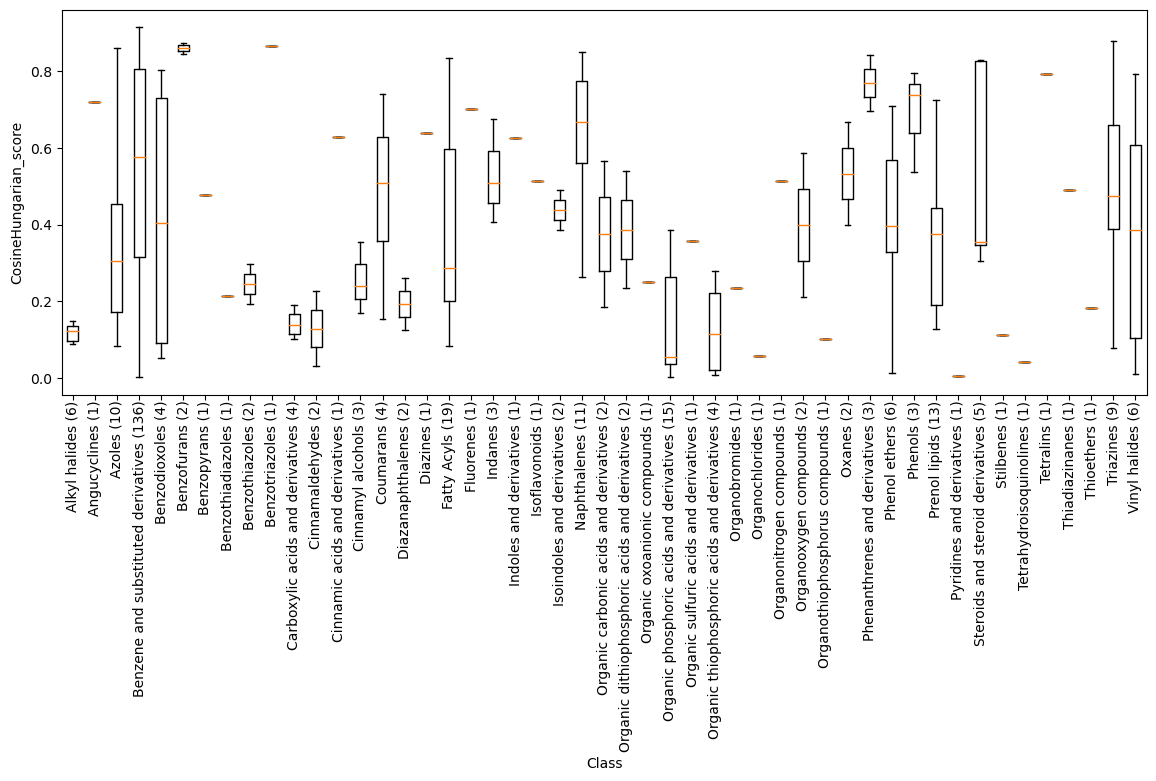

In [12]:
make_boxplot(merged_df.groupby('class'), 'CosineHungarian_score')

In [13]:
# g = merged_df.groupby('class')
# g = g.get_group('Benzodioxoles')
# #print(g)
# g.boxplot(column='CosineHungarian_score', by='class')
# plt.show()


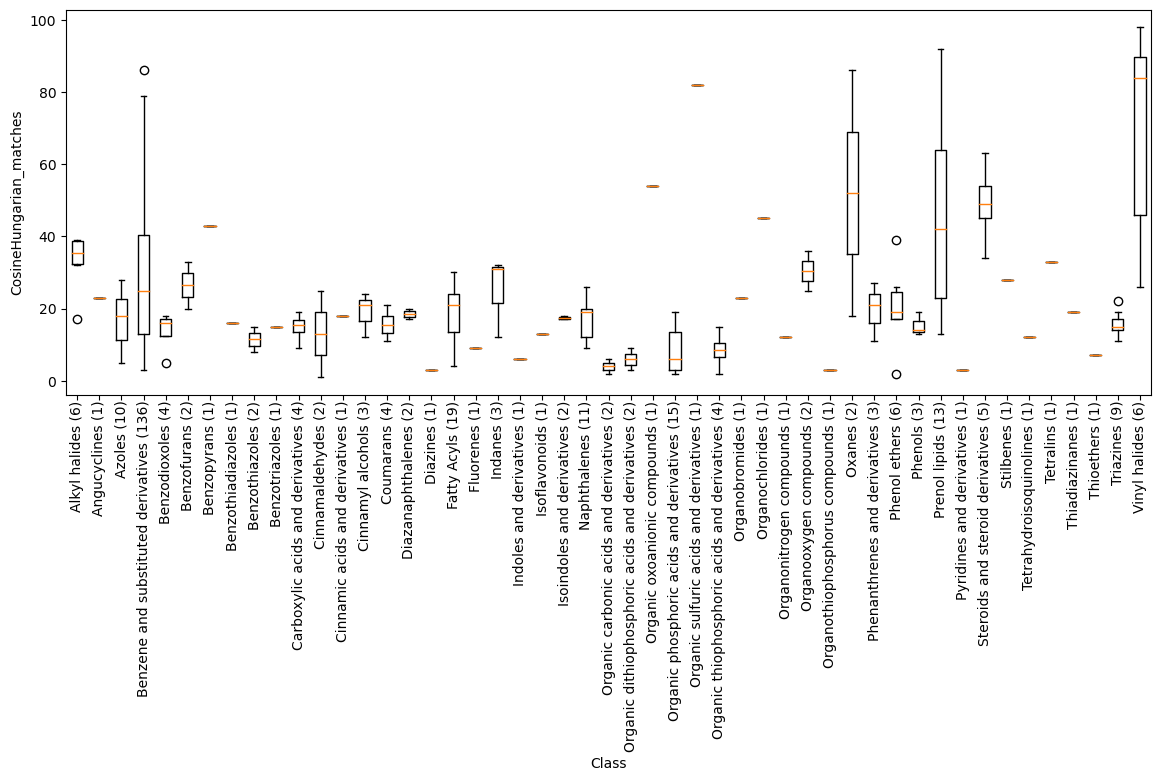

In [14]:
make_boxplot(merged_df.groupby('class'), 'CosineHungarian_matches')

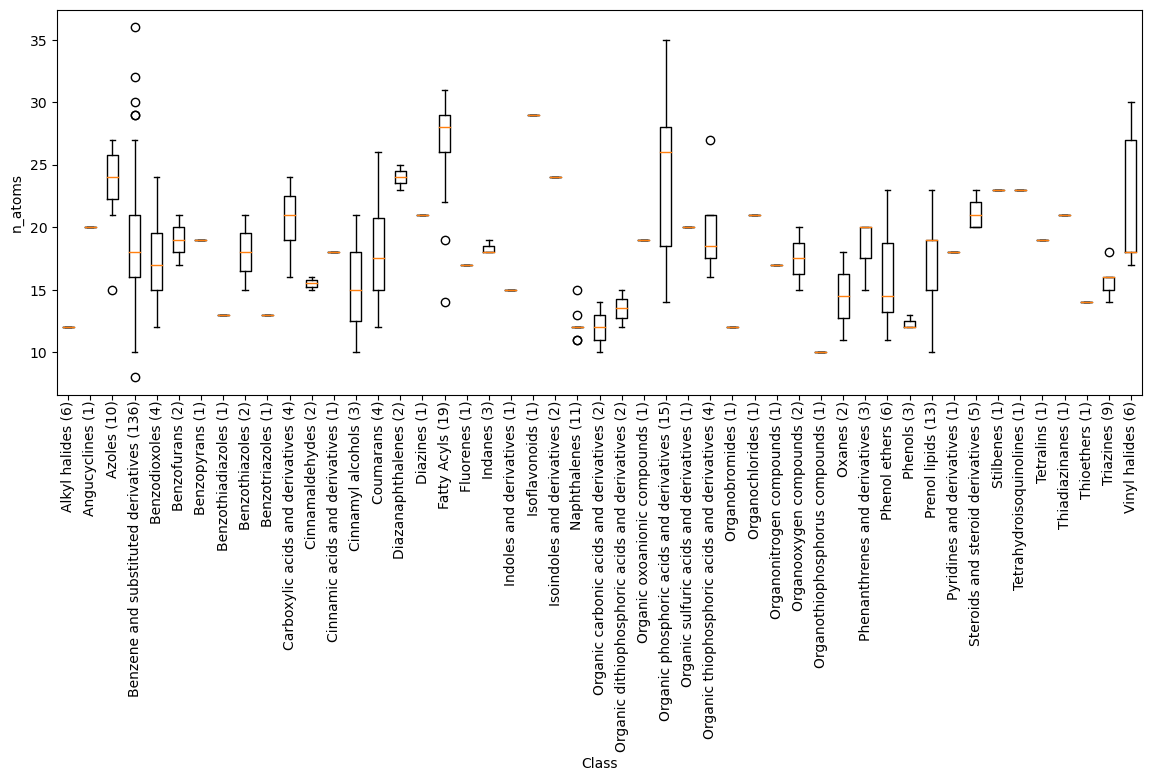

In [15]:
make_boxplot(merged_df.groupby('class'), 'n_atoms')

In [16]:
def plot_boxplot(df, class_col, score_col):
    # group the DataFrame by the class column and calculate the median of each group
    medians = df.groupby(class_col)[score_col].median()

    # sort the groups based on their median values
    sorted_groups = medians.sort_values().index

    # sort the DataFrame based on the sorted group order
    sorted_df = df.astype({class_col: pd.CategoricalDtype(categories=sorted_groups)})
    sorted_df = sorted_df.sort_values(by=class_col)

    # create a figure with one subplot
    fig, ax1 = plt.subplots(1, figsize=(16, 6))

    # plot the boxplot sorted by median in the subplot
    scores = [sorted_df.loc[sorted_df.loc[:, class_col] == group, score_col] for group in sorted_groups]
    positions = list(range(1, len(sorted_groups) + 1))
    labels = [f"{group} ({len(sorted_df.loc[sorted_df.loc[:, class_col] == group])})" for group in sorted_groups]
    ax1.boxplot(x=scores, positions=positions, labels=labels)
    ax1.set_xticks(positions)
    ax1.set_xticklabels(labels, rotation=90)
    ax1.tick_params(axis='x', which='major', pad=0.5 * plt.rcParams['font.size'])
    ax1.set_xlabel(class_col)
    ax1.set_ylabel(score_col)
    ax1.set_title('Boxplot')

    # display the subplot
    plt.show()

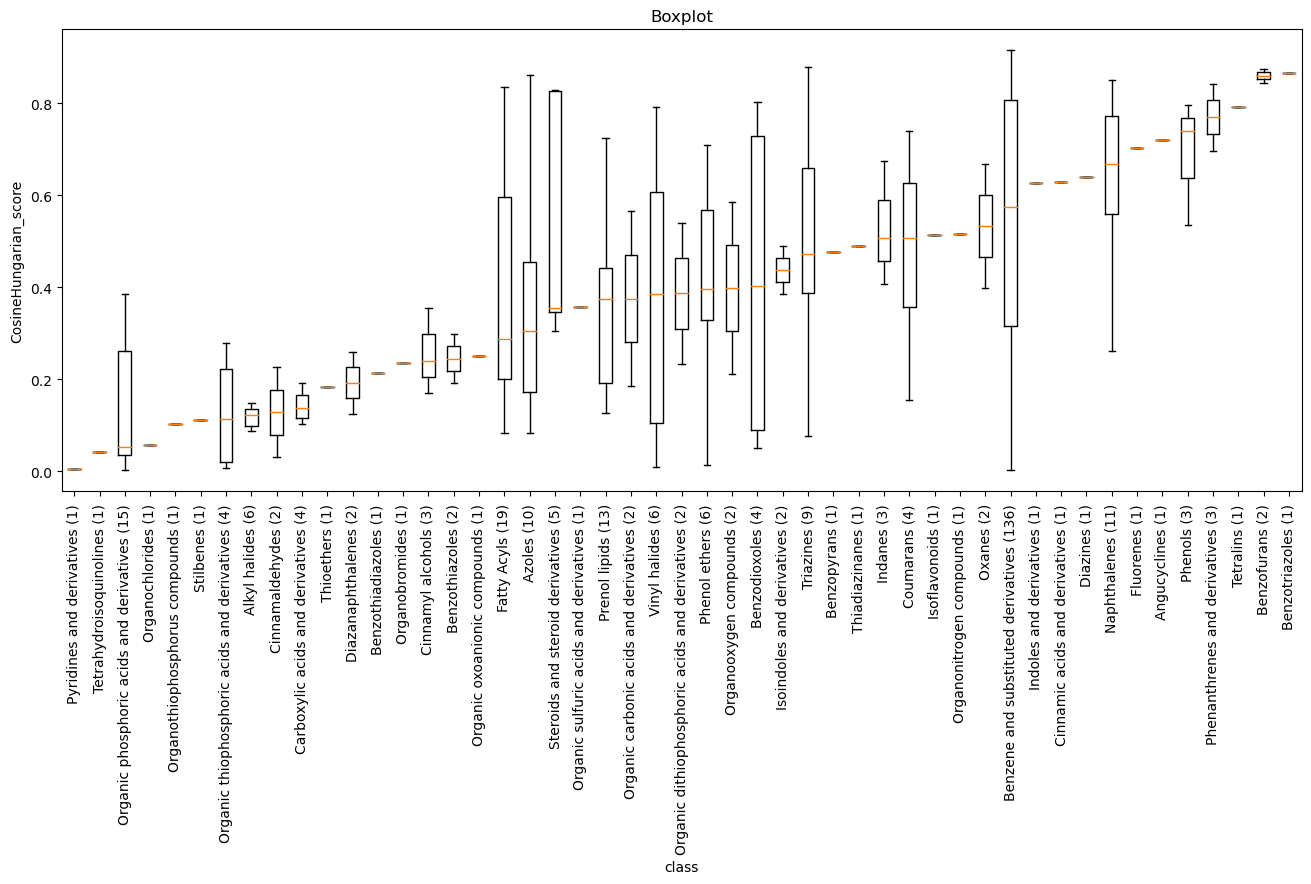

In [17]:
plot_boxplot(merged_df, 'class', 'CosineHungarian_score')

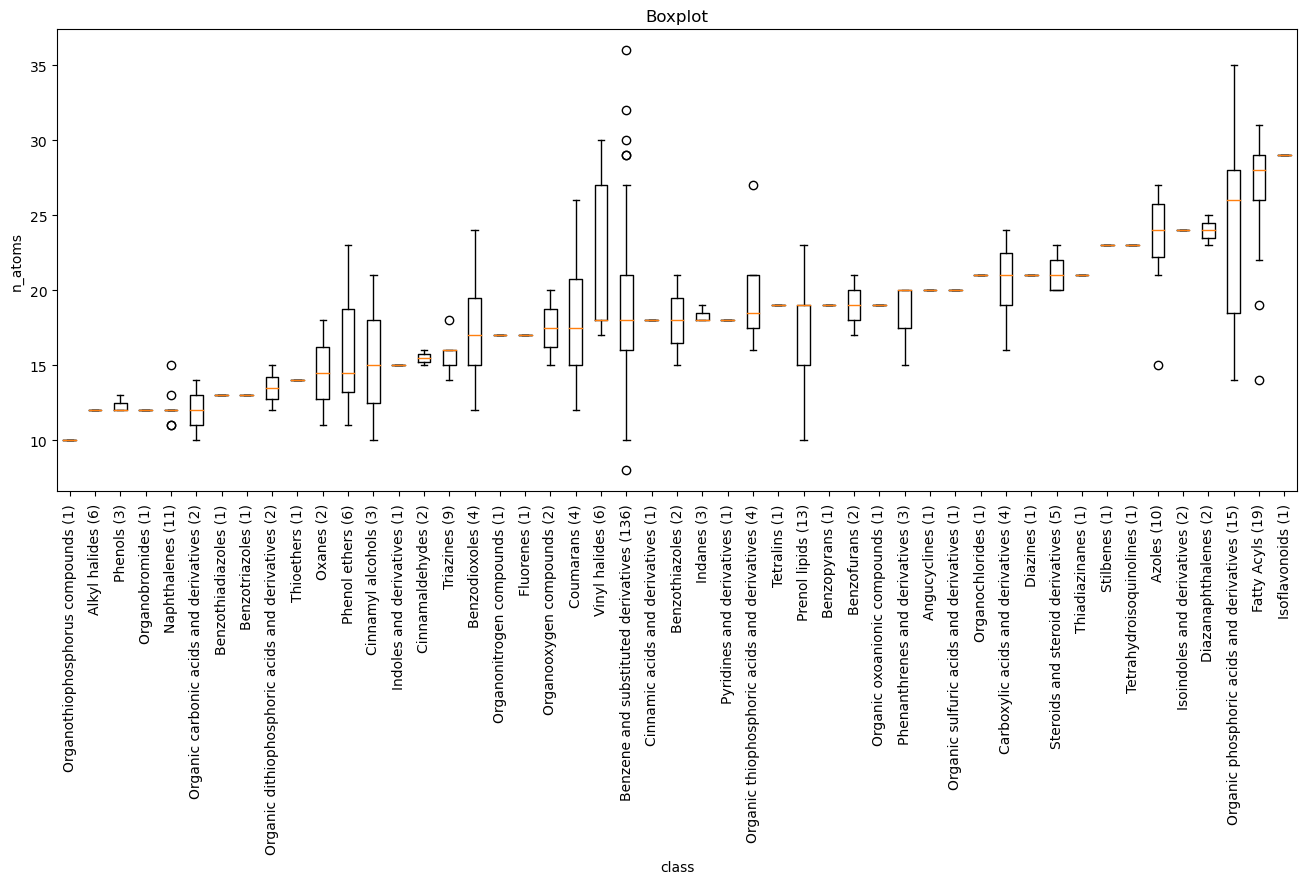

In [18]:
plot_boxplot(merged_df, 'class', 'n_atoms')

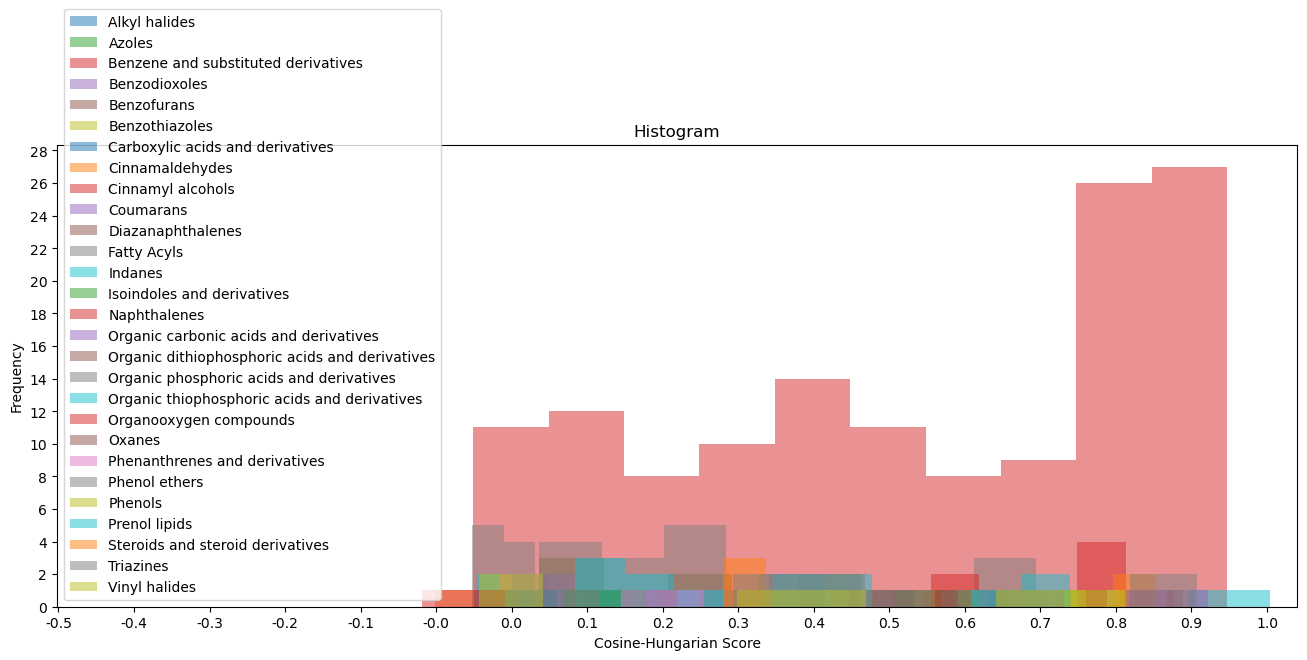

In [19]:


# group the DataFrame by the 'class' column
grouped_df = merged_df.groupby('class')

# create a figure with one subplot
fig, ax1 = plt.subplots(1, figsize=(16, 6))

# plot a histogram of the 'CosineHungarian_score' column for each group
for group_name, group_df in grouped_df:
    freq = len(group_df)
    if freq > 1:
        ax1.hist(group_df['CosineHungarian_score'], alpha=0.5, label=group_name)
    else:
        ax1.hist(group_df['CosineHungarian_score'], alpha=0.5)

# set the x-axis label, y-axis label, and title
ax1.set_xlabel('Cosine-Hungarian Score')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram')

# set the x-axis ticks and tick labels
x_min = merged_df['CosineHungarian_score'].min()
x_max = merged_df['CosineHungarian_score'].max()
x_range = x_max - x_min
x_ticks = np.arange(x_min-0.5, x_max+1.0, x_range/10)
x_tick_labels = [str(round(x, 1)) for x in x_ticks]
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)

# set the x-axis range
ax1.set_xlim([-0.5, 1.0])

# set the y-axis ticks and tick labels
y_max = ax1.get_ylim()[1]
y_ticks = np.arange(0, y_max+1, 2)
ax1.set_yticks(y_ticks)

# add a legend to the plot for groups with frequency greater than 1
handles, labels = ax1.get_legend_handles_labels()
handles_filtered = []
labels_filtered = []
for handle, label in zip(handles, labels):
    if label != '' and label not in labels_filtered:
        labels_filtered.append(label)
        handles_filtered.append(handle)
ax1.legend(handles_filtered, labels_filtered)

# display the plot
plt.show()

AxesSubplot(0.125,0.11;0.352273x0.77)


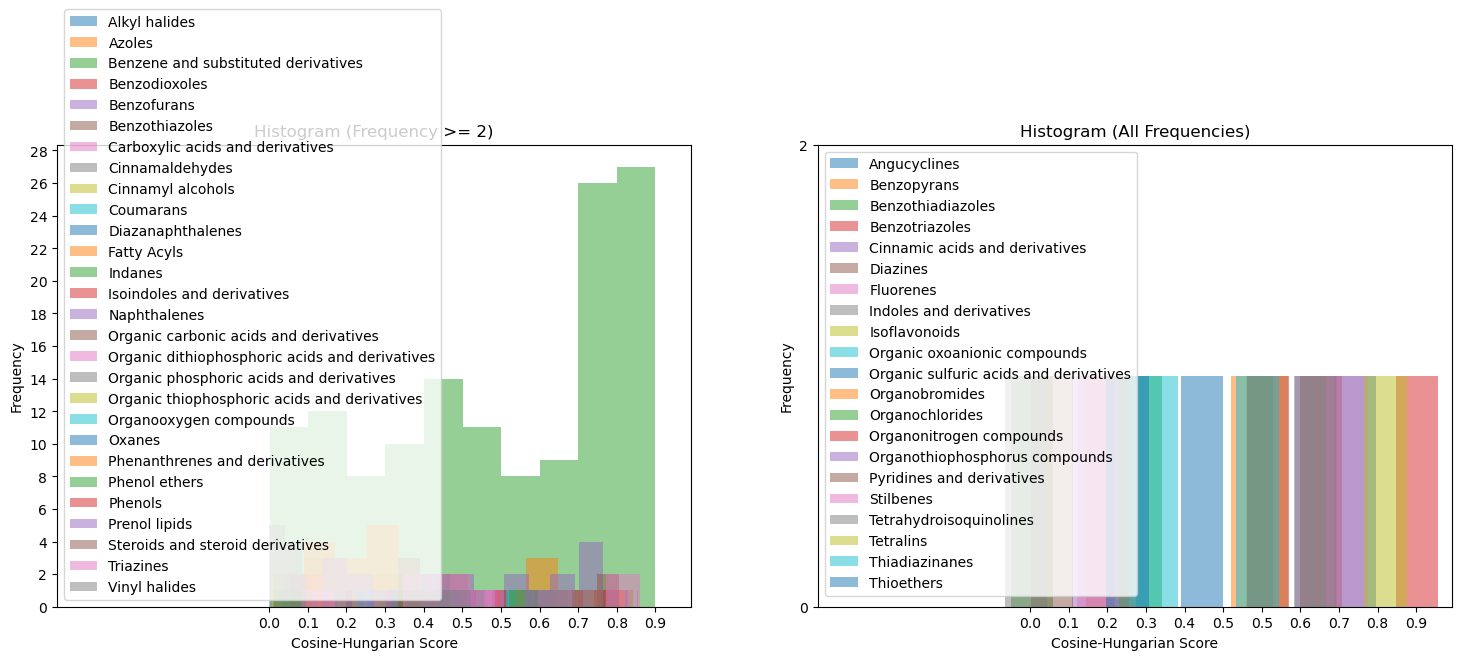

In [20]:


# group the DataFrame by the 'class' column
grouped_df = merged_df.groupby('class')

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1]})

# plot a histogram of the 'CosineHungarian_score' column for each group
for group_name, group_df in grouped_df:
    freq = len(group_df)
    if freq >= 2:
        ax1.hist(group_df['CosineHungarian_score'], alpha=0.5, label=group_name)
    else:
        ax2.hist(group_df['CosineHungarian_score'], alpha=0.5, label=group_name)
print(ax1)

# set the x-axis label, y-axis label, and title for both subplots
ax1.set_xlabel('Cosine-Hungarian Score')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram (Frequency >= 2)')

ax2.set_xlabel('Cosine-Hungarian Score')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram (All Frequencies)')

# set the x-axis ticks and tick labels for both subplots
x_min = merged_df['CosineHungarian_score'].min()
x_max = merged_df['CosineHungarian_score'].max()
x_range = x_max - x_min
x_ticks = np.arange(x_min-0.0, x_max+1.0, x_range/10)
x_tick_labels = [str(round(x, 1)) for x in x_ticks]
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)

ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_tick_labels)

# set the x-axis range for both subplots
ax1.set_xlim([-0.5, 1.0])
ax2.set_xlim([-0.5, 1.0])

# set the y-axis ticks and tick labels for both subplots
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
y_ticks1 = np.arange(0, y_max+1, 2)
y_ticks2 = np.arange(0, 3, 2)
ax1.set_yticks(y_ticks1)
ax2.set_yticks(y_ticks2)

# add a legend to both subplots
handles, labels = ax1.get_legend_handles_labels()
handles_filtered = []
labels_filtered = []
for handle, label in zip(handles, labels):
    if label != '' and label not in labels_filtered:
        labels_filtered.append(label)
        handles_filtered.append(handle)
ax1.legend(handles_filtered, labels_filtered)

handles, labels = ax2.get_legend_handles_labels()
handles_filtered = []
labels_filtered = []
for handle, label in zip(handles, labels):
    if label != '' and label not in labels_filtered:
        labels_filtered.append(label)
        handles_filtered.append(handle)
ax2.legend(handles_filtered, labels_filtered)

# display the plot
plt.show()